<a href="https://colab.research.google.com/github/moyrml/MIDL_DTC/blob/master/Copy_of_nn_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MATHEMATICAL METHODS FOR ENGINEERING**
## Homework \#3: Artificial Neural Network

For this assigment you will build a neural network model. The dataset for this assignment comes from the UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/index.php). This data was collected in 1978 and each of the 506 entries represents aggregate information about 14 features of homes from various suburbs located in Boston.

The features you will use as inputs include:

* **CRIM**: This is the per capita crime rate by town
* **ZN**: This is the proportion of residential land zoned for lots larger than 25,000 sq.ft.
* **INDUS**: This is the proportion of non-retail business acres per town.
* **CHAS**: This is the Charles River dummy variable (this is equal to 1 if tract bounds river; 0 otherwise)
* **NOX**: This is the nitric oxides concentration (parts per 10 million)
* **RM**: This is the average number of rooms per dwelling
* **AGE**: This is the proportion of owner-occupied units built prior to 1940
* **DIS**: This is the weighted distances to five Boston employment centers
* **RAD**: This is the index of accessibility to radial highways
* **TAX**: This is the full-value property-tax rate per $10,000
* **PTRATIO**: This is the pupil-teacher ratio by town
* **B**: This is calculated as 1000(Bk — 0.63)², where Bk is the proportion of people of African American descent by town
* **LSTAT**: This is the percentage lower status of the population

The feature the network will try to assess is **MEDV**,the median value of owner-occupied homes in \$1000s.

The code below prepares the data for the network. Create a model with **three hidden layers** then train it and evaluate its performance with the dataset reserved for the test. Provide the mean square error calculated using the predicted and true values. (The trivial guess in this case would be the mean of **MEDV** which yields mse=99.05, your network just needs to get a better score than this).

In [ ]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state=1)

X_shape=X_train.shape
print("Number of samples for training is:",X_shape[0])
print("Number of features for training is:",X_shape[1])

print("The mean square error for the trivial guess:" ,np.mean(np.square(np.mean(y_test)*np.ones(y_test.shape)-y_test)))

Number of samples for training is: 379
Number of features for training is: 13
The mean square error for the trivial guess: 99.0584735569471


## Prepare data

In [ ]:
mu = X_train.mean(0)
sigma = X_train.std(0)

# X_train = (X_train - mu) / sigma
# X_test= (X_test - mu) / sigma

X_train.mean(0), X_train.std(0)

(array([3.80518264e+00, 1.15211082e+01, 1.12200528e+01, 8.17941953e-02,
        5.54072823e-01, 6.25572559e+00, 6.87514512e+01, 3.82443298e+00,
        9.52506596e+00, 4.05182058e+02, 1.84781003e+01, 3.58304802e+02,
        1.29361741e+01]),
 array([9.36346879e+00, 2.34616304e+01, 6.86628588e+00, 2.74050917e-01,
        1.17669185e-01, 6.86507607e-01, 2.82391757e+01, 2.13562569e+00,
        8.72301899e+00, 1.69259917e+02, 2.13860620e+00, 8.94835052e+01,
        7.23381920e+00]))

## Cool nn stuff
### Hyperparameters

In [ ]:
batch_size = 32
lr = 1e-3
epochs = 100

### Network and data handling
Of course, pytorch is the only way to go...
First, we define:

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

class Model(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.Linear(13,64)
    self.acc1 = nn.ReLU()
    self.bn1 = nn.BatchNorm1d(64)
    self.fc2 = nn.Linear(64,64)
    self.acc2 = nn.ReLU()
    self.bn2 = nn.BatchNorm1d(64)
    self.fc3 = nn.Linear(64,1)

  def forward(self,x):
    x = self.fc1(x)
    x = self.bn1(x)
    x = self.acc1(x)
    x = self.fc2(x)
    x = self.bn2(x)
    x = self.acc2(x)
    x = self.fc3(x)

    return x

class ds(Dataset):
  def __init__(self, x, y=None):
    super().__init__()

    self.X = x
    self.Y = y

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self,idx):
    if self.Y is not None:
      return torch.Tensor(self.X[idx,:]).float(), torch.Tensor([self.Y[idx]]).float()
    return self.X[idx,:].astype(np.float64)


Next we use:

In [ ]:
model = Model()
optimizer = Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

train_set = ds(X_train, y_train)
test_set = ds(X_test, y_test)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size*4)

In [ ]:
epoch_train_losses = []
epoch_test_losses = []

for epoch in range(epochs):
  model.train()

  epoch_train_loss = 0
  for batch_id, (x, y_true) in enumerate(train_loader):
    out = model(x.float())

    optimizer.zero_grad()
    loss = criterion(out, y_true.float())
    loss.backward()
    optimizer.step()

    epoch_train_loss += loss.item() / len(train_loader)

  epoch_train_losses.append(epoch_train_loss)

  model.eval()
  epoch_test_loss = 0
  with torch.no_grad():
    for batch_id, (x, y_true) in enumerate(test_loader):
      out = model(x)
      loss = criterion(out, y_true)

      epoch_test_loss += loss.item() / len(test_loader)

  epoch_test_losses.append(epoch_test_loss)

  print(f'Epoch {epoch}: Train MSE: {epoch_train_loss:0.4e}\tTest MSE: {epoch_test_loss:0.4e}')

Epoch 0: Train MSE: 5.7459e+02	Test MSE: 6.2768e+02
Epoch 1: Train MSE: 5.5059e+02	Test MSE: 6.1133e+02
Epoch 2: Train MSE: 5.2983e+02	Test MSE: 5.8344e+02
Epoch 3: Train MSE: 5.1498e+02	Test MSE: 5.6349e+02
Epoch 4: Train MSE: 4.9484e+02	Test MSE: 5.4543e+02
Epoch 5: Train MSE: 4.7685e+02	Test MSE: 5.2336e+02
Epoch 6: Train MSE: 4.5771e+02	Test MSE: 5.0045e+02
Epoch 7: Train MSE: 4.3890e+02	Test MSE: 4.8347e+02
Epoch 8: Train MSE: 4.1901e+02	Test MSE: 4.5924e+02
Epoch 9: Train MSE: 3.9822e+02	Test MSE: 4.2857e+02
Epoch 10: Train MSE: 3.7962e+02	Test MSE: 3.9296e+02
Epoch 11: Train MSE: 3.5565e+02	Test MSE: 3.3881e+02
Epoch 12: Train MSE: 3.3229e+02	Test MSE: 2.9049e+02
Epoch 13: Train MSE: 3.0983e+02	Test MSE: 2.5588e+02
Epoch 14: Train MSE: 2.8519e+02	Test MSE: 2.3975e+02
Epoch 15: Train MSE: 2.6477e+02	Test MSE: 2.2336e+02
Epoch 16: Train MSE: 2.4152e+02	Test MSE: 2.0502e+02
Epoch 17: Train MSE: 2.2028e+02	Test MSE: 2.1705e+02
Epoch 18: Train MSE: 1.9979e+02	Test MSE: 2.0355e+02
Epo

See the training process.

Text(0, 0.5, 'MSE')

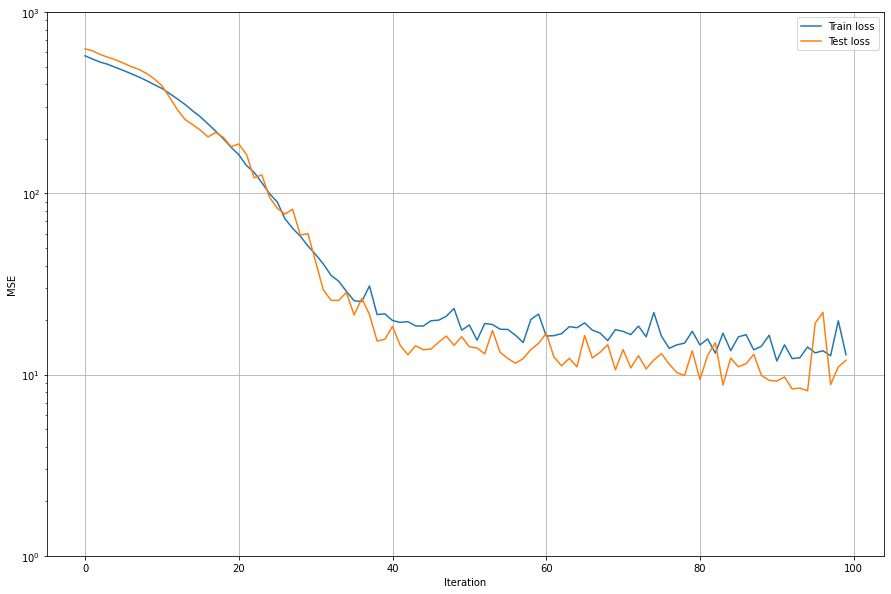

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.plot(np.arange(len(epoch_train_losses)), epoch_train_losses, label='Train loss')
plt.plot(np.arange(len(epoch_test_losses)), epoch_test_losses, label='Test loss')
plt.legend()
plt.grid()
plt.yscale('log')
plt.ylim([1e0, 1e3])
plt.xlabel('Iteration')
plt.ylabel('MSE')

### Predict

Lets see what we got.

In [ ]:
predictions = []
labels = []

with torch.no_grad():
  for batch_id, (x, y_true) in enumerate(test_loader):
    out = model(x)
    labels.extend(y_true.squeeze().tolist())
    predictions.extend(out.squeeze().tolist())

predictions = np.array(predictions)
labels = np.array(labels)

mse_over_test = np.mean((labels - predictions)**2)
print(f'MSE over test set: {mse_over_test}')

MSE over test set: 12.001468649511587


Text(0, 0.5, 'Predicted - True')

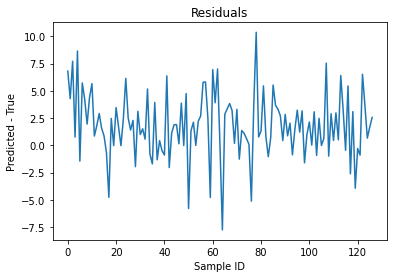

In [ ]:
plt.plot(predictions - labels)
plt.title('Residuals')
plt.xlabel('Sample ID')
plt.ylabel('Predicted - True')

Text(0, 0.5, '(Predicted - True) / True')

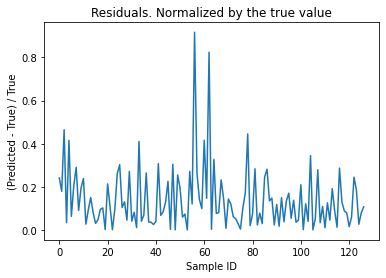

In [ ]:
plt.plot(np.abs(predictions - labels) / labels)
plt.title('Residuals. Normalized by the true value')
plt.xlabel('Sample ID')
plt.ylabel('(Predicted - True) / True')

Better than 99.